Ref:https://github.com/hkaneko1985/python_data_analysis_ohmsha/blob/master/sample_functions.py  
Ref:https://github.com/hkaneko1985/python_data_analysis_ohmsha/blob/master/sample_program_4_8.py

In [10]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
#import sample_functions
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.spatial.distance import cdist

In [3]:
dataset = pd.read_csv('train.csv', index_col=0)

In [4]:
dataset.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,days,weeks
age,,,,,,,,,,,,,,,,,,
31,7,1,1,0,12294,1,0,0,21,11,101,3,498,0,1,0,326.0,47.0
29,2,2,2,0,43027,0,0,0,22,8,158,2,702,0,3,1,236.0,34.0
35,4,1,2,0,12252,1,0,0,11,11,351,1,826,0,0,0,316.0,45.0
31,9,1,1,0,99121,1,1,2,16,5,658,2,120,0,0,0,138.0,20.0
48,10,1,0,0,42005,1,0,1,3,4,177,1,273,0,3,0,94.0,13.0


In [22]:
svr_cs = 2 ** np.arange(-5, 11, dtype=float)  # C の候補
svr_epsilons = 2 ** np.arange(-10, 1, dtype=float)  # ε の候補
svr_gammas = 2 ** np.arange(-20, 11, dtype=float)  # γ の候補
fold_number = 5  # N-fold CV の N
number_of_test_samples = len(dataset)*0.2  # テストデータのサンプル数。20%のデータを使用

In [5]:
# データ分割
y = dataset["y"]  # 目的変数
x = dataset.drop(["y"], axis=1)  # 説明変数

# ランダムにトレーニングデータとテストデータとに分割
# random_state に数字を与えることで、別のときに同じ数字を使えば、ランダムとはいえ同じ結果にすることができます
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=number_of_test_samples, random_state=0)

In [6]:
# オートスケーリング
autoscaled_x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
autoscaled_x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0, ddof=1)

In [8]:
def gamma_optimization_with_variance(x, gammas):
    """
    DataFrame型もしくは array 型の x において、カーネル関数におけるグラム行列の分散を最大化することによって
    γ を最適化する関数
    Parameters
    ----------
    x: pandas.DataFrame or numpy.array
    gammas: list
    Returns
    -------
    optimized gamma : scalar
    
    """
    print('カーネル関数において、グラム行列の分散を最大化することによる γ の最適化')
    variance_of_gram_matrix = list()
    for index, ocsvm_gamma in enumerate(gammas):
        print(index + 1, '/', len(gammas))
        gram_matrix = np.exp(-ocsvm_gamma * cdist(x, x, metric='sqeuclidean'))
        variance_of_gram_matrix.append(gram_matrix.var(ddof=1))
    return gammas[variance_of_gram_matrix.index(max(variance_of_gram_matrix))]

In [11]:
# グラム行列の分散を最大化することによる γ の最適化
optimal_svr_gamma = gamma_optimization_with_variance(autoscaled_x_train, svr_gammas)

カーネル関数において、グラム行列の分散を最大化することによる γ の最適化
1 / 31
2 / 31
3 / 31
4 / 31
5 / 31
6 / 31
7 / 31
8 / 31
9 / 31
10 / 31
11 / 31
12 / 31
13 / 31
14 / 31
15 / 31
16 / 31
17 / 31
18 / 31
19 / 31
20 / 31
21 / 31
22 / 31
23 / 31
24 / 31
25 / 31
26 / 31
27 / 31
28 / 31
29 / 31
30 / 31
31 / 31


In [12]:
# CV による ε の最適化
model_in_cv = GridSearchCV(svm.SVR(kernel='rbf', C=3, gamma=optimal_svr_gamma), 
                           {'epsilon': svr_epsilons}, cv=fold_number, iid=False)
model_in_cv.fit(autoscaled_x_train, autoscaled_y_train)
optimal_svr_epsilon = model_in_cv.best_params_['epsilon']

/Users/hasegawatooru/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [13]:
# CV による C の最適化
model_in_cv = GridSearchCV(svm.SVR(kernel='rbf', epsilon=optimal_svr_epsilon, gamma=optimal_svr_gamma),
                           {'C': svr_cs}, cv=fold_number, iid=False)
model_in_cv.fit(autoscaled_x_train, autoscaled_y_train)
optimal_svr_c = model_in_cv.best_params_['C']

/Users/hasegawatooru/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [14]:
# CV による γ の最適化
model_in_cv = GridSearchCV(svm.SVR(kernel='rbf', epsilon=optimal_svr_epsilon, C=optimal_svr_c),
                           {'gamma': svr_gammas}, cv=fold_number, iid=False)
model_in_cv.fit(autoscaled_x_train, autoscaled_y_train)
optimal_svr_gamma = model_in_cv.best_params_['gamma']

/Users/hasegawatooru/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [15]:
# 最適化された C, ε, γ
print('C : {0}\nε : {1}\nGamma : {2}'.format(optimal_svr_c, optimal_svr_epsilon, optimal_svr_gamma))

C : 16.0
ε : 0.25
Gamma : 0.03125


In [16]:
# SVR
model = svm.SVR(kernel='rbf', C=optimal_svr_c, epsilon=optimal_svr_epsilon, gamma=optimal_svr_gamma)  # モデルの宣言
model.fit(autoscaled_x_train, autoscaled_y_train)  # モデルの構築

SVR(C=16.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.25, gamma=0.03125,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [17]:
import matplotlib.figure as figure
import matplotlib.pyplot as plt
from sklearn import metrics

In [18]:
def estimation_and_performance_check_in_regression_train_and_test(model, x_train, y_train, x_test, y_test):
    # トレーニングデータの推定
    estimated_y_train = model.predict(x_train) * y_train.std() + y_train.mean()  # y を推定し、スケールをもとに戻します
    estimated_y_train = pd.DataFrame(estimated_y_train, index=x_train.index,
                                     columns=['estimated_y'])  # Pandas の DataFrame 型に変換。行の名前・列の名前も設定
    
    # トレーニングデータの実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18  # 横軸や縦軸の名前の文字などのフォントのサイズ
    plt.figure(figsize=figure.figaspect(1))  # 図の形を正方形に
    plt.scatter(y_train, estimated_y_train.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y_train.max(), estimated_y_train.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y_train.min(), estimated_y_train.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
             [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.show()  # 以上の設定で描画

    # トレーニングデータのr2, RMSE, MAE
    print('r^2 for training data :', metrics.r2_score(y_train, estimated_y_train))
    print('RMSE for training data :', metrics.mean_squared_error(y_train, estimated_y_train) ** 0.5)
    print('MAE for training data :', metrics.mean_absolute_error(y_train, estimated_y_train))

    # トレーニングデータの結果の保存
    y_train_for_save = pd.DataFrame(y_train)  # Series のため列名は別途変更
    y_train_for_save.columns = ['actual_y']
    y_error_train = y_train_for_save.iloc[:, 0] - estimated_y_train.iloc[:, 0]
    y_error_train = pd.DataFrame(y_error_train)  # Series のため列名は別途変更
    y_error_train.columns = ['error_of_y(actual_y-estimated_y)']
    results_train = pd.concat([estimated_y_train, y_train_for_save, y_error_train], axis=1)
    results_train.to_csv('estimated_y_train.csv')  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

    # テストデータの推定
    estimated_y_test = model.predict(x_test) * y_train.std() + y_train.mean()  # y を推定し、スケールをもとに戻します
    estimated_y_test = pd.DataFrame(estimated_y_test, index=x_test.index,
                                    columns=['estimated_y'])  # Pandas の DataFrame 型に変換。行の名前・列の名前も設定
   
    # テストデータの実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18  # 横軸や縦軸の名前の文字などのフォントのサイズ
    plt.figure(figsize=figure.figaspect(1))  # 図の形を正方形に
    plt.scatter(y_test, estimated_y_test.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y_test.max(), estimated_y_test.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y_test.min(), estimated_y_test.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
             [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.show()  # 以上の設定で描画

    # テストデータのr2, RMSE, MAE
    print('r^2 for test data :', metrics.r2_score(y_test, estimated_y_test))
    print('RMSE for test data :', metrics.mean_squared_error(y_test, estimated_y_test) ** 0.5)
    print('MAE for test data :', metrics.mean_absolute_error(y_test, estimated_y_test))

    # テストデータの結果の保存
    y_test_for_save = pd.DataFrame(y_test)  # Series のため列名は別途変更
    y_test_for_save.columns = ['actual_y']
    y_error_test = y_test_for_save.iloc[:, 0] - estimated_y_test.iloc[:, 0]
    y_error_test = pd.DataFrame(y_error_test)  # Series のため列名は別途変更
    y_error_test.columns = ['error_of_y(actual_y-estimated_y)']
    results_test = pd.concat([estimated_y_test, y_test_for_save, y_error_test], axis=1)
    results_test.to_csv('estimated_y_test.csv')  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

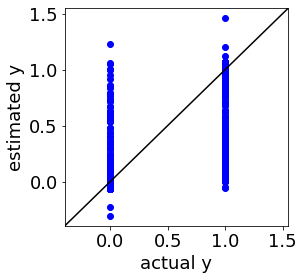

r^2 for training data : 0.14078035266760025
RMSE for training data : 0.24835719403891215
MAE for training data : 0.11782106951718793


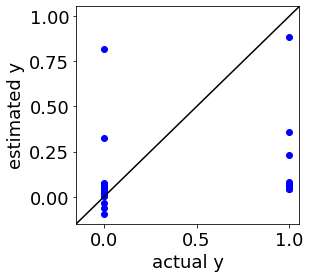

r^2 for test data : 0.05891414451353971
RMSE for test data : 0.2821998873018296
MAE for test data : 0.13917804532236874


In [20]:
# トレーニングデータ・テストデータの推定、実測値 vs. 推定値のプロット、r2, RMSE, MAE の値の表示、推定値の保存
estimation_and_performance_check_in_regression_train_and_test(model, autoscaled_x_train, y_train,
                                                                               autoscaled_x_test, y_test)